# Data Enhencement 
## 1. Retrieve Data from MongoDB     
Retrieve all documents from MongoDB and convert it to a pandas dataframe.

In [1]:
import pymongo
client = pymongo.MongoClient()

In [2]:
import pandas as pd
from datetime import datetime
# pip install -U statsmodels
# pip install -U scikit-learn

In [3]:
db = client.get_database("crime")
collection = db.get_collection("crime")
data = list(collection.find())
df = pd.DataFrame.from_records(data)
df.drop('_id', axis=1, inplace=True)
df['arst_date'] = pd.to_datetime(df['arst_date'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31140 entries, 0 to 31139
Data columns (total 17 columns):
rpt_id             31140 non-null object
arst_date          31140 non-null datetime64[ns]
time               31137 non-null object
area               31140 non-null object
area_desc          31140 non-null object
rd                 31140 non-null object
age                31140 non-null object
sex_cd             31140 non-null object
descent_cd         31140 non-null object
chrg_grp_cd        27655 non-null object
grp_description    27630 non-null object
arst_typ_cd        31140 non-null object
charge             31140 non-null object
chrg_desc          27658 non-null object
location           31140 non-null object
location_1         31140 non-null object
crsst              15633 non-null object
dtypes: datetime64[ns](1), object(16)
memory usage: 4.0+ MB
None


In [5]:
df.head()

,rpt_id,arst_date,time,area,area_desc,rd,age,sex_cd,descent_cd,chrg_grp_cd,grp_description,arst_typ_cd,charge,chrg_desc,location,location_1,crsst
0,5486296,2018-12-01,1750,21,Topanga,2156,24,M,B,24,Miscellaneous Other Violations,F,594(A)(1)PC,DEFACE PROPERTY,21600 VICTORY BL,"{'latitude': '34.188', 'longitude': '-118.6002...",NaN
1,181522098,2018-12-01,1340,15,N Hollywood,1513,39,M,O,16,Narcotic Drug Laws,M,11350HS,POSSESS CONTROLLED SUBSTANCE,12600 HART ST,"{'latitude': '34.1976', 'longitude': '-118.407...",NaN
2,5486256,2018-12-01,1650,18,Southeast,1822,36,M,B,09,Forgery/Counterfeit,F,529PC,FALSE PERSONATE:SPEC CIRC,MAIN ST,"{'latitude': '33.9456', 'longitude': '-118.273...",CENTURY BL
3,5485582,2018-12-01,0110,13,Newton,1309,29,M,W,24,Miscellaneous Other Violations,F,594(A)(1)PC,DEFACE PROPERTY,BAY ST,"{'latitude': '34.0315', 'longitude': '-118.232...",MATEO
4,5486192,2018-12-01,1945,11,Northeast,1148,39,M,H,22,Driving Under Influence,F,23153(A)VC,DUI ALCOHOL CAUSING INJURY,MARMION,"{'latitude': '34.0966', 'longitude': '-118.208...",AVENUE 45


## 2. Time Series Forecasting


In [6]:
from pmdarima.arima import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa as tsa
import plotly as ply
from collections import Counter
import pmdarima as pm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams.update({'font.size': 16})
# !pip install pmdarima
# !pip install seaborn

In [7]:
# df1 = df[df['area'] == '13'][['arst_date']]
crime_dic = Counter(df['arst_date'])
df2 = pd.Series(crime_dic, name = 'crime_num').to_frame()
df2['time_lags'] = range(1, len(df2['crime_num'])+1)

In [8]:
df2

,crime_num,time_lags
2018-12-01,418,1
2018-12-02,212,2
2018-12-03,203,3
2018-12-04,229,4
2018-12-05,229,5
...,...,...
2019-04-02,266,123
2019-04-03,295,124
2019-04-04,271,125
2019-04-05,264,126


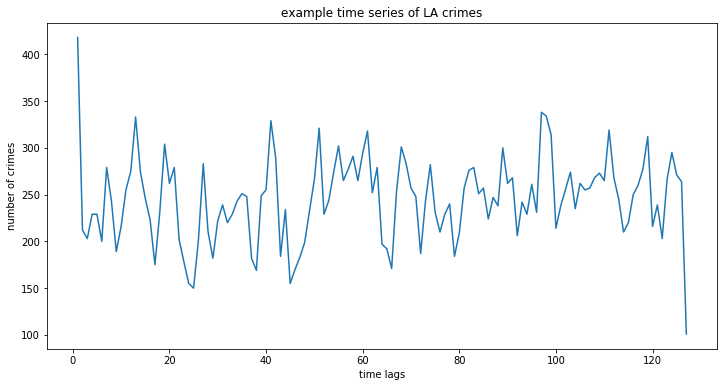

In [9]:
# plot an example time series plot of LA crimes(total)
plt.figure(figsize = (12,6))
plt.title("example time series of LA crimes")
plt.plot(df2['time_lags'], df2['crime_num'])
plt.xlabel("time lags")
plt.ylabel("number of crimes")
plt.show()

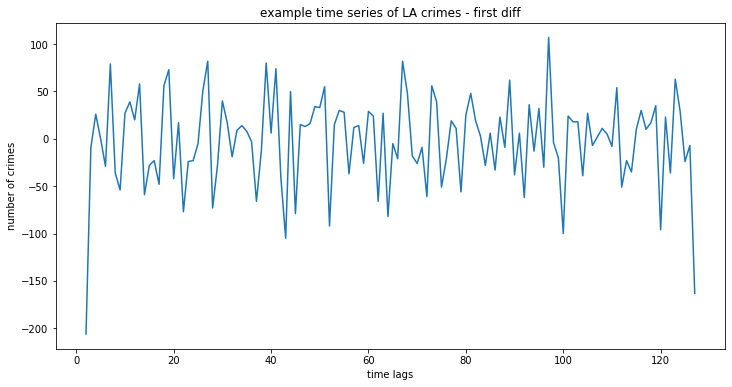

In [10]:
## Chasing stationarity by using first differencing
diff1 = df2['crime_num'].diff()
plt.figure(figsize = (12,6))
plt.title("example time series of LA crimes - first diff")
plt.plot(df2['time_lags'], diff1)
plt.xlabel("time lags")
plt.ylabel("number of crimes")
plt.show()

In [11]:
## Use Augmented Dickey-Fuller test for first differenced data stationary testing
result = tsa.stattools.adfuller(diff1[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.816947
p-value: 0.000000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


**Test result suggested that stationarity is acheived by applying first differencing since p-val is small, so we will set d = 1 in model fitting process. In the mean time, we won't assume**

In [12]:
stepwise_fit = pm.auto_arima(df2['crime_num'], start_p=1, start_q=1, max_p=5, max_q=5,
                             seasonal=False, d=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True,
                             stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=1312.523, BIC=1323.868, Fit time=0.216 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1338.985, BIC=1344.657, Fit time=0.011 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1338.193, BIC=1346.702, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=1328.744, BIC=1337.253, Fit time=0.115 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1337.325, BIC=1340.162, Fit time=0.010 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=1312.001, BIC=1326.182, Fit time=0.230 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 2) seasonal_order=

In [13]:
next_25_step = stepwise_fit.predict(n_periods=25)
next_25_step

/workspace/.pip-modules/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.



array([176.37037551, 240.17286355, 259.02510244, 257.80099188,
       254.1680046 , 252.66632083, 252.60404271, 252.89439136,
       253.11992311, 253.25562886, 253.35808905, 253.45909718,
       253.56487537, 253.67322573, 253.78204774, 253.89067642,
       253.99913279, 254.10753678, 254.21594354, 254.32436029,
       254.43278148, 254.54120319, 254.64962442, 254.75804533,
       254.86646616])

In [14]:
rs_fit = pm.auto_arima(df2['crime_num'], start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                       start_P=0, seasonal=False, d=1, D=1, trace=True,
                       n_jobs=-1,  
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=False, random=True, random_state=124, 
                       n_fits = 20)

Total fit time: 3.742 seconds


In [15]:
next_25_rs = rs_fit.predict(n_periods=25)
next_25_rs

/workspace/.pip-modules/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning:

Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.



array([188.66587051, 207.13822581, 260.76521798, 306.23308707,
       309.07362169, 269.7171934 , 221.10241109, 201.36310267,
       224.12090052, 269.42891782, 301.13076342, 295.69305351,
       259.60493735, 222.60408695, 213.37777781, 237.50711818,
       274.52698854, 295.24090034, 284.74635543, 253.08144222,
       226.01437736, 224.24849525, 247.75885025, 277.03413021,
       289.26919432])

In [16]:
# Baseline model is prediccting the simple average
def baseline_model(area = False, wholeLA = False):
    if wholeLA:
        crime_dic = Counter(df['arst_date'])
        df2 = pd.Series(crime_dic, name = 'crime_num').to_frame()
        result = np.mean(df2['crime_num'])
        
        
    if area:
        if area < 10:
            area = '0' + str(area)
        else:
            area = str(area)
            
        df1 = df[df['area'] == area][['arst_date']]
        crime_dic = Counter(df1['arst_date'])
        df2 = pd.Series(crime_dic, name = 'crime_num').to_frame()
        result = np.mean(df2['crime_num'])
    
    return result

In [17]:
baseline_model(1)

25.078740157480315

In [32]:
fig = go.Figure(data = [go.Scatter(x = df2['time_lags'], y = df2['crime_num'])])
fig.show()

In [35]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Scatter(y=[1, 3, 2], line=dict(color="crimson"))],
    layout=dict(title=dict(text="A Chart"))
)
fig.show()